# Generate the time series of TN

In [1]:
import numpy as np

# Seed for reproducibility
np.random.seed(42)

def generate_TN_time_series(duration=40000, on_time=2000, off_time=5000, on_amp=1, off_amp=-1, perturbation=True):
    """
    Generate a TN time series with specified parameters and optional perturbations.

    Parameters:
    - duration: Total duration of the time series in years.
    - on_time, off_time: Duration of the on and off states in years.
    - on_amp, off_amp: Amplitudes for the on and off states.
    - perturbation: Whether to apply random perturbations to the amplitudes and durations.

    Returns:
    - A numpy array representing the TN time series.
    """
    time_series = []
    time = 0
    np.random.seed(42)

    while time < duration:
        # Apply random perturbations
        current_on_time = on_time + np.random.uniform(0, 1000) if perturbation else on_time
        current_off_time = off_time + np.random.uniform(0, 1000) if perturbation else off_time
        current_on_amp = on_amp + np.random.uniform(0, 0.3) if perturbation else on_amp
        current_off_amp = off_amp + np.random.uniform(0, 0.3) if perturbation else off_amp

        # Ensure the series does not exceed the specified duration
        if time + current_on_time <= duration:
            time_series.extend([current_on_amp] * int(current_on_time))
            time += current_on_time
        else:
            break

        if time + current_off_time <= duration:
            time_series.extend([current_off_amp] * int(current_off_time))
            time += current_off_time
        else:
            break

    return np.array(time_series)

# Generate the TN time series
tn_time_series = generate_TN_time_series()

# Display the first 100 data points to get a sense of the series
tn_time_series[:100]


array([1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959818,
       1.21959818, 1.21959818, 1.21959818, 1.21959818, 1.21959

# Plot the TN

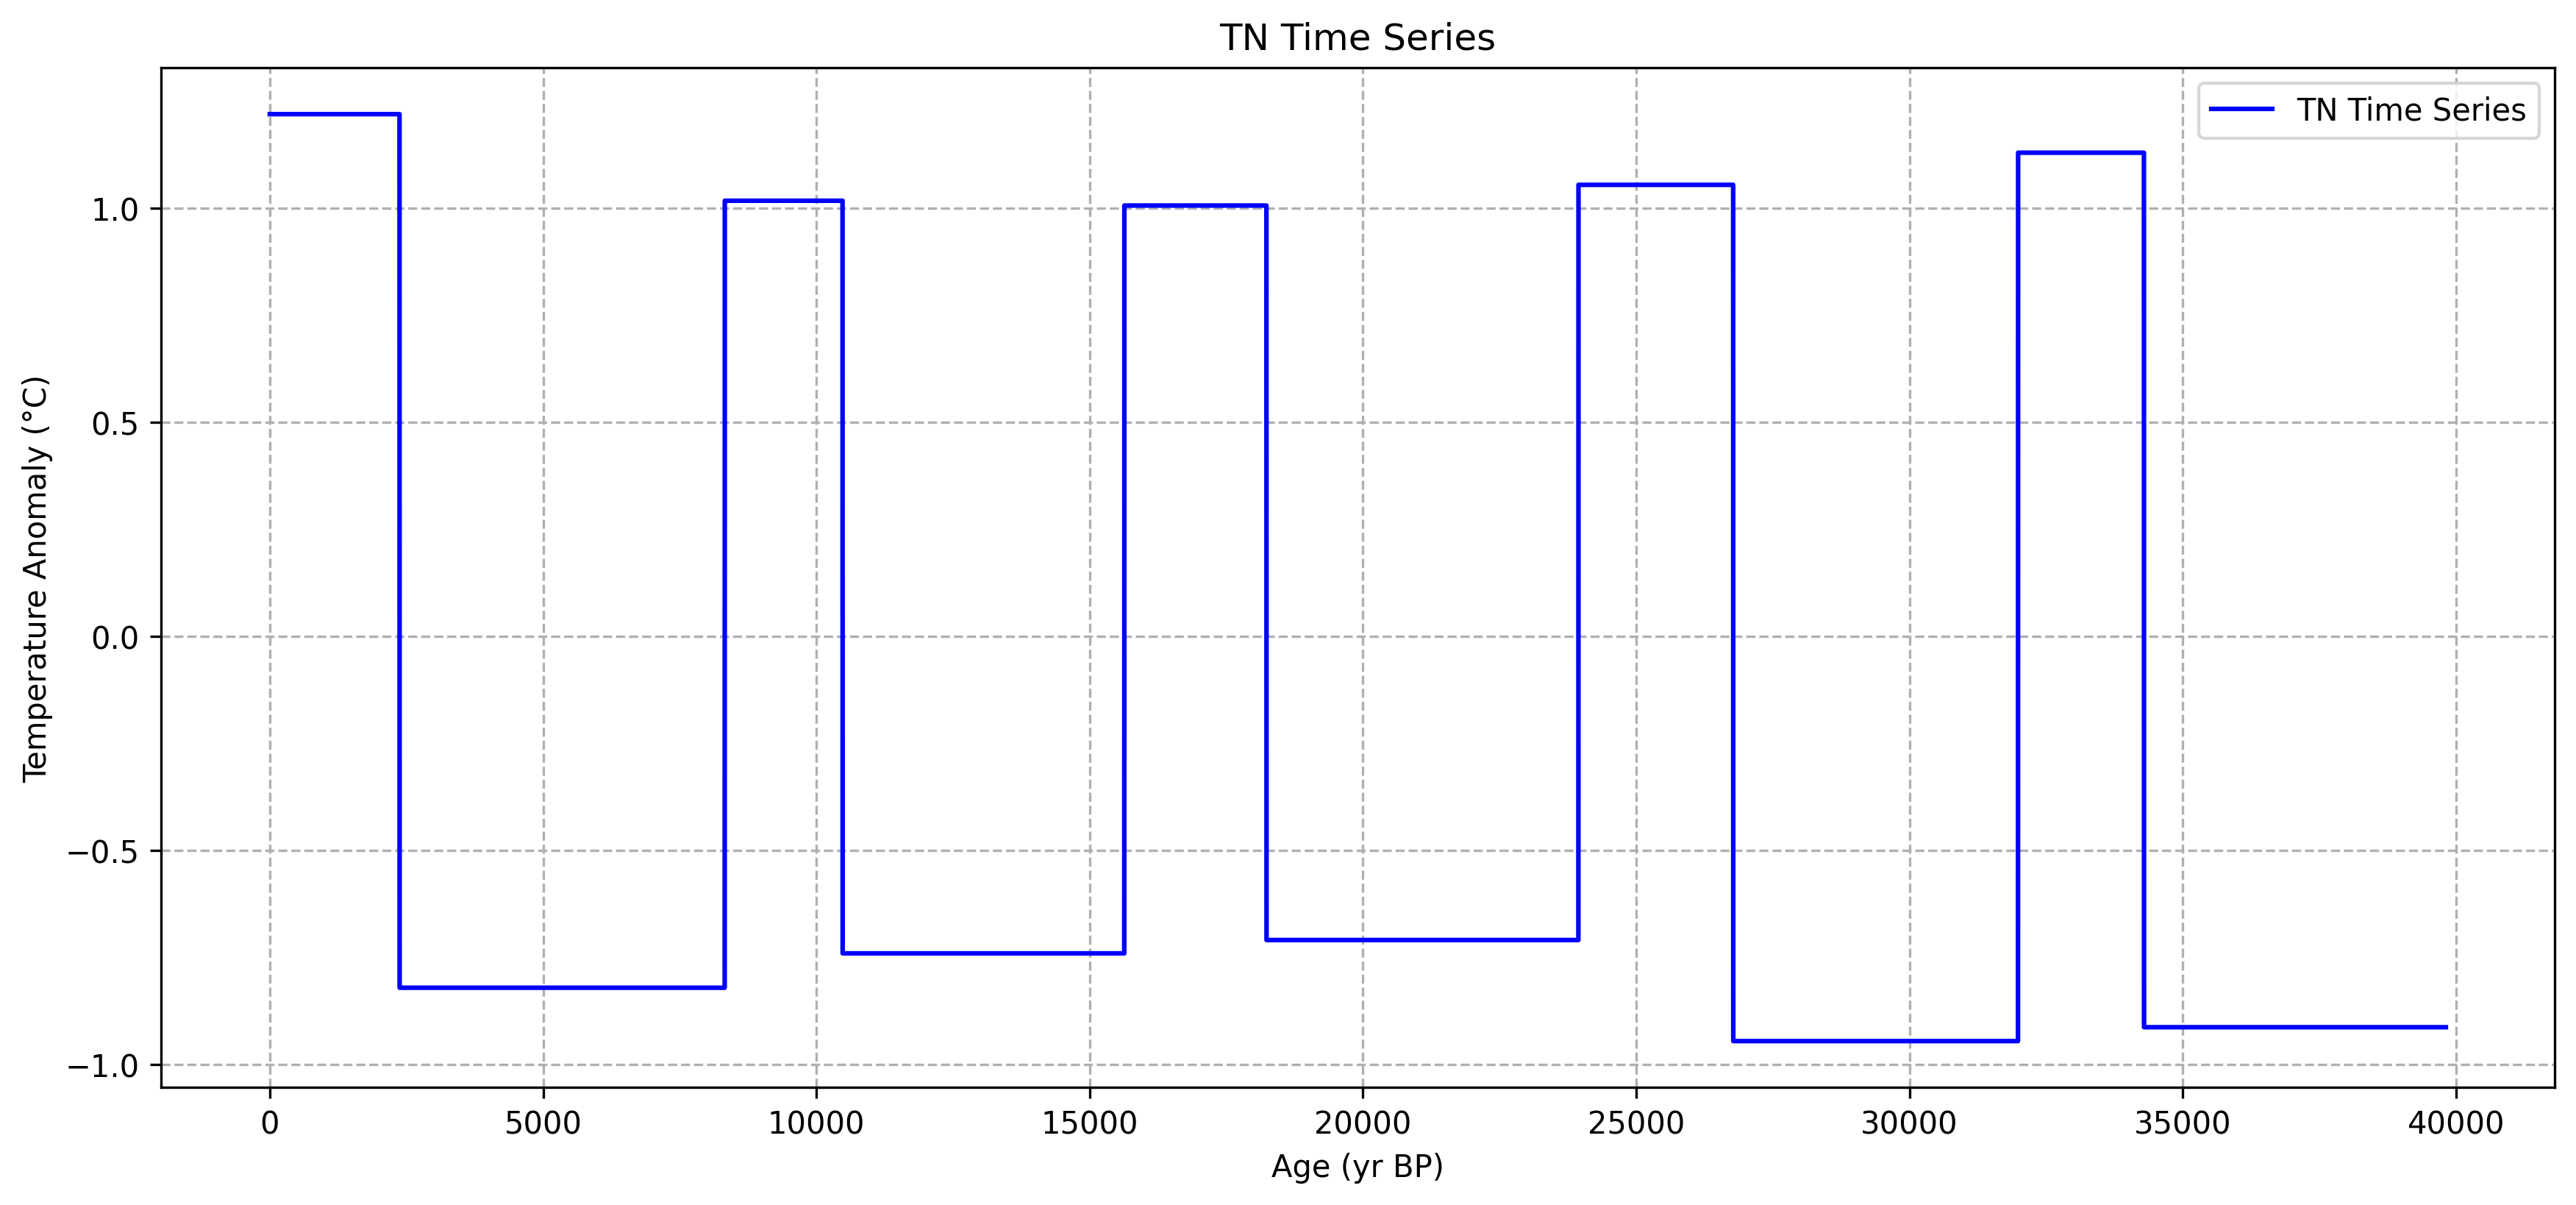

In [2]:
import matplotlib.pyplot as plt

# Plot the generated TN time series without using a function
plt.figure(figsize=(14, 6),dpi=300)
plt.plot(tn_time_series, label='TN Time Series', color='b')
plt.xlabel('Age (yr BP)')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('TN Time Series')
# add grid with linestyle '--'
plt.grid(linestyle='--')
plt.legend()
plt.show()


# The model

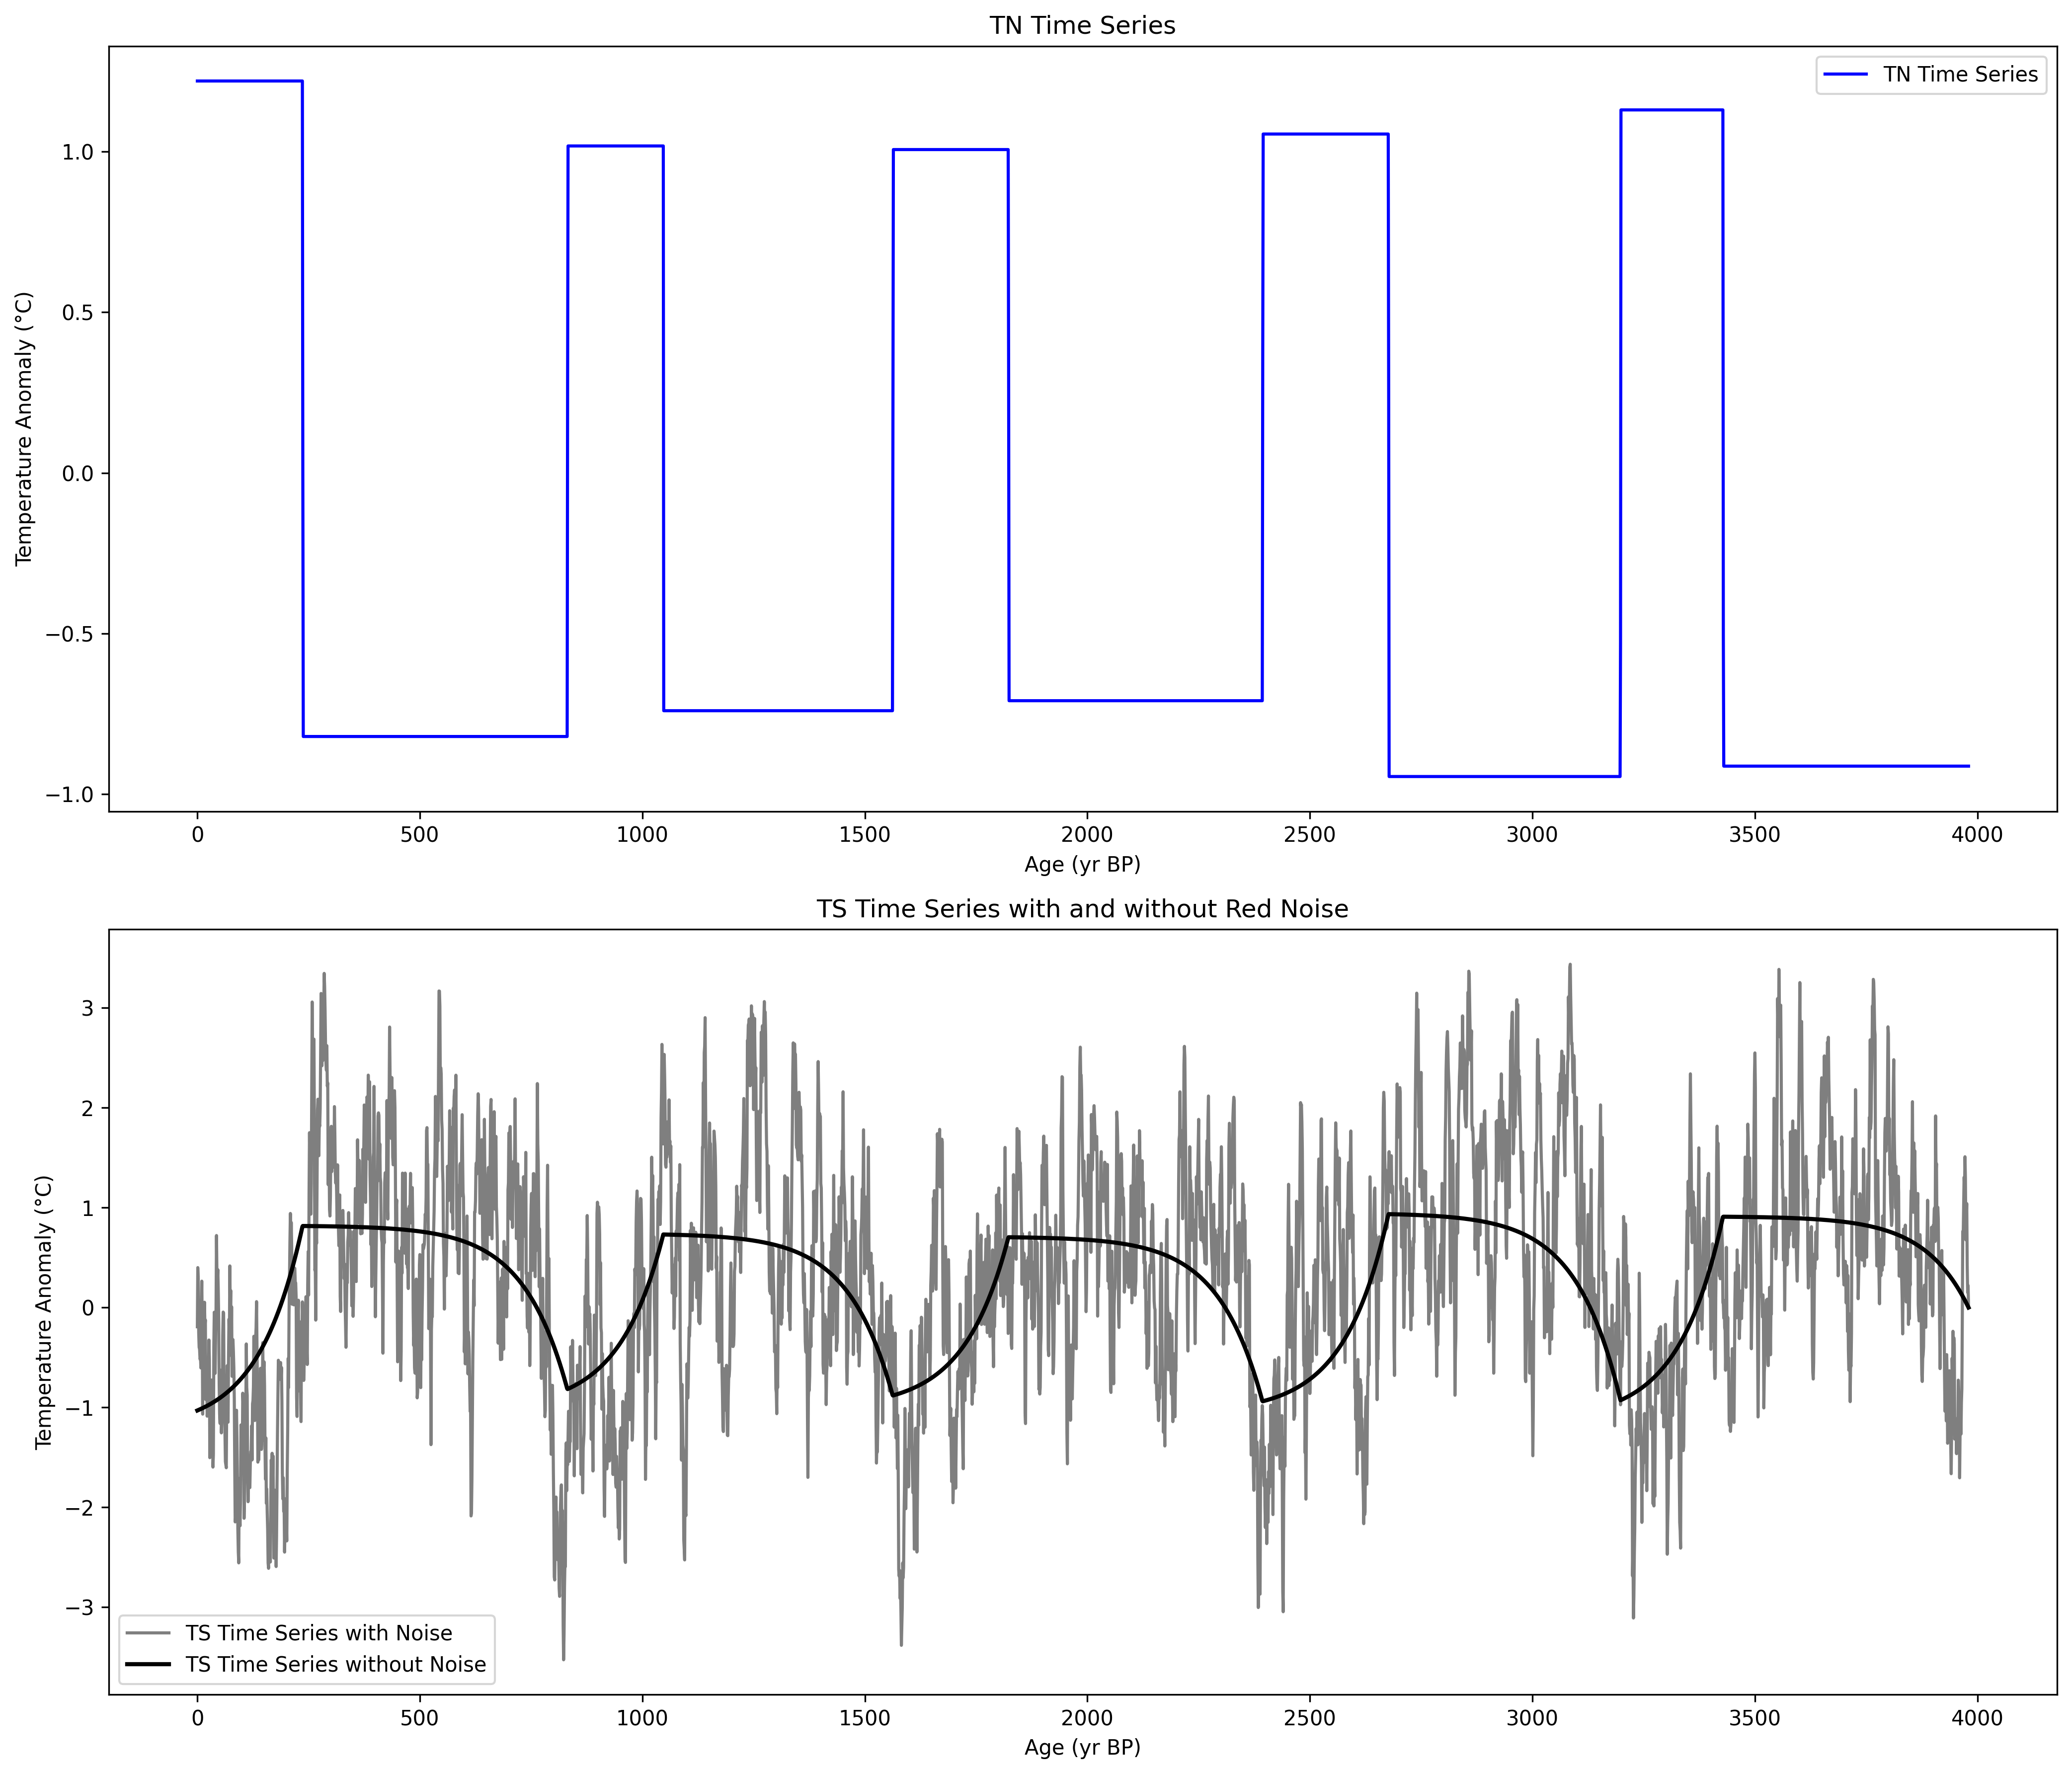

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Resample TN time series to match timestep dt of 10 years
def resample_TN(tn_series, dt=10):
    # Calculate the number of periods in the resampled series
    num_periods = len(tn_series) // dt
    # Resample by averaging over each dt period
    resampled_tn = np.array([np.mean(tn_series[i*dt:(i+1)*dt]) for i in range(num_periods)])
    return resampled_tn

# Parameters for the model
dt = 10  # Time step in years
tau = 1000  # Characteristic timescale in years
TS_initial = 0  # Initial condition for TS
a = 0.9  # Red noise parameter
std_dev = 0.1  # Standard deviation for the white noise component

# Generate and resample a shorter TN time series
tn_time_series_shortened = generate_TN_time_series(duration=40000)
tn_time_series_resampled = resample_TN(tn_time_series_shortened, dt)

# Calculate TS without noise, reversing the calculation direction
TS_without_noise_reversed = np.zeros(len(tn_time_series_resampled))
TS_without_noise_reversed[-1] = TS_initial
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise_reversed[i+1])
    TS_without_noise_reversed[i] = TS_without_noise_reversed[i+1] + delta_TS

# Adjust the standard deviation for red noise based on the variance of TS without noise
variance_TS_without_noise = np.var(TS_without_noise_reversed)
adjusted_std_dev = np.sqrt(variance_TS_without_noise / 2)

np.random.seed(42)
# Generate adjusted red noise
red_noise_reversed = np.zeros(len(tn_time_series_resampled))
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    epsilon_t = np.random.normal(0, adjusted_std_dev)
    red_noise_reversed[i] = a * red_noise_reversed[i+1] + epsilon_t

# Add adjusted red noise to TS without noise
TS_with_adjusted_noise_reversed = TS_without_noise_reversed + red_noise_reversed

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 12),dpi=300)
axs[0].plot(tn_time_series_resampled, label='TN Time Series', color='blue')
axs[0].set_title('TN Time Series')
axs[0].set_xlabel('Age (yr BP)')
axs[0].set_ylabel('Temperature Anomaly (°C)')
axs[0].legend()

axs[1].plot(TS_with_adjusted_noise_reversed, label='TS Time Series with Noise', color='k', alpha=0.5,linestyle='-')
axs[1].plot(TS_without_noise_reversed, label='TS Time Series without Noise', color='k', linewidth=2, linestyle='-')
axs[1].set_title('TS Time Series with and without Red Noise')
axs[1].set_xlabel('Age (yr BP)')
axs[1].set_ylabel('Temperature Anomaly (°C)')
axs[1].legend()

plt.tight_layout()
plt.show()


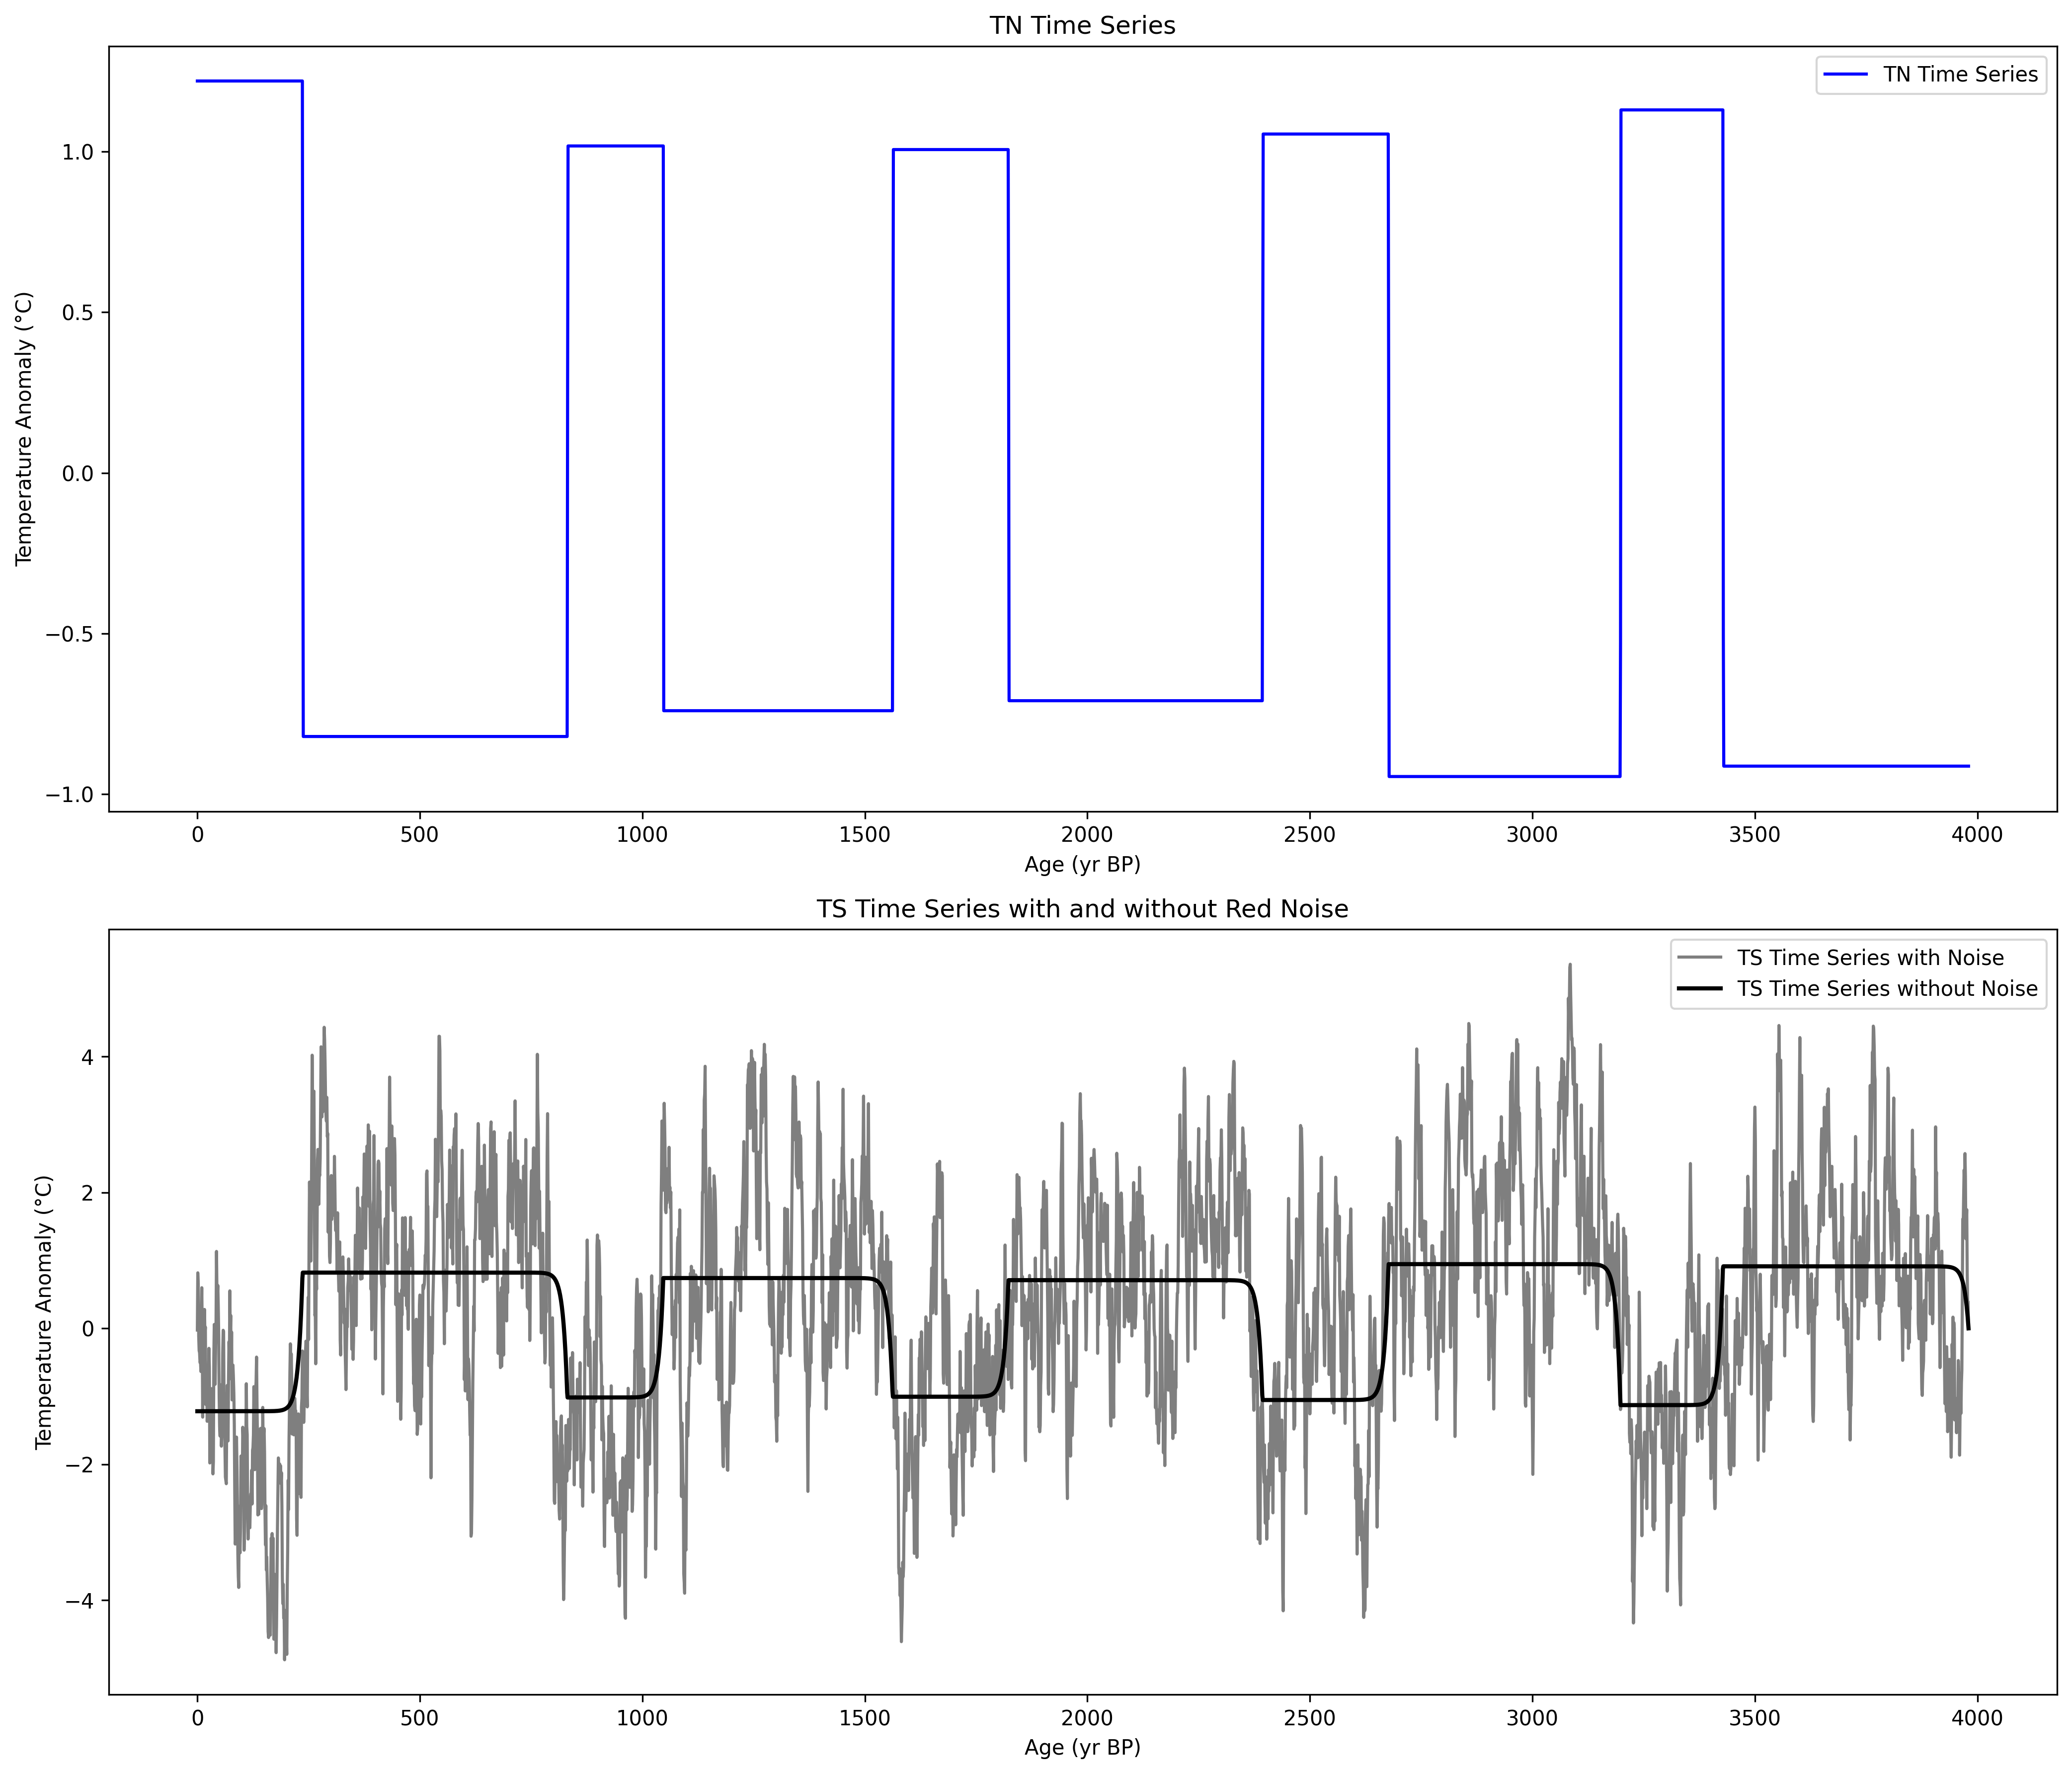

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Resample TN time series to match timestep dt of 10 years
def resample_TN(tn_series, dt=10):
    # Calculate the number of periods in the resampled series
    num_periods = len(tn_series) // dt
    # Resample by averaging over each dt period
    resampled_tn = np.array([np.mean(tn_series[i*dt:(i+1)*dt]) for i in range(num_periods)])
    return resampled_tn

# Parameters for the model
dt = 10  # Time step in years
tau = 100  # Characteristic timescale in years
TS_initial = 0  # Initial condition for TS
a = 0.9  # Red noise parameter
std_dev = 0.1  # Standard deviation for the white noise component

# Generate and resample a shorter TN time series
tn_time_series_shortened = generate_TN_time_series(duration=40000)
tn_time_series_resampled = resample_TN(tn_time_series_shortened, dt)

# Calculate TS without noise, reversing the calculation direction
TS_without_noise_reversed = np.zeros(len(tn_time_series_resampled))
TS_without_noise_reversed[-1] = TS_initial
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise_reversed[i+1])
    TS_without_noise_reversed[i] = TS_without_noise_reversed[i+1] + delta_TS

# Adjust the standard deviation for red noise based on the variance of TS without noise
variance_TS_without_noise = np.var(TS_without_noise_reversed)
adjusted_std_dev = np.sqrt(variance_TS_without_noise / 2)

np.random.seed(42)
# Generate adjusted red noise
red_noise_reversed = np.zeros(len(tn_time_series_resampled))
for i in range(len(tn_time_series_resampled) - 2, -1, -1):
    epsilon_t = np.random.normal(0, adjusted_std_dev)
    red_noise_reversed[i] = a * red_noise_reversed[i+1] + epsilon_t

# Add adjusted red noise to TS without noise
TS_with_adjusted_noise_reversed = TS_without_noise_reversed + red_noise_reversed

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(14, 12),dpi=300)
axs[0].plot(tn_time_series_resampled, label='TN Time Series', color='blue')
axs[0].set_title('TN Time Series')
axs[0].set_xlabel('Age (yr BP)')
axs[0].set_ylabel('Temperature Anomaly (°C)')
axs[0].legend()

axs[1].plot(TS_with_adjusted_noise_reversed, label='TS Time Series with Noise', color='k', alpha=0.5,linestyle='-')
axs[1].plot(TS_without_noise_reversed, label='TS Time Series without Noise', color='k', linewidth=2, linestyle='-')
axs[1].set_title('TS Time Series with and without Red Noise')
axs[1].set_xlabel('Age (yr BP)')
axs[1].set_ylabel('Temperature Anomaly (°C)')
axs[1].legend()

plt.tight_layout()
plt.show()


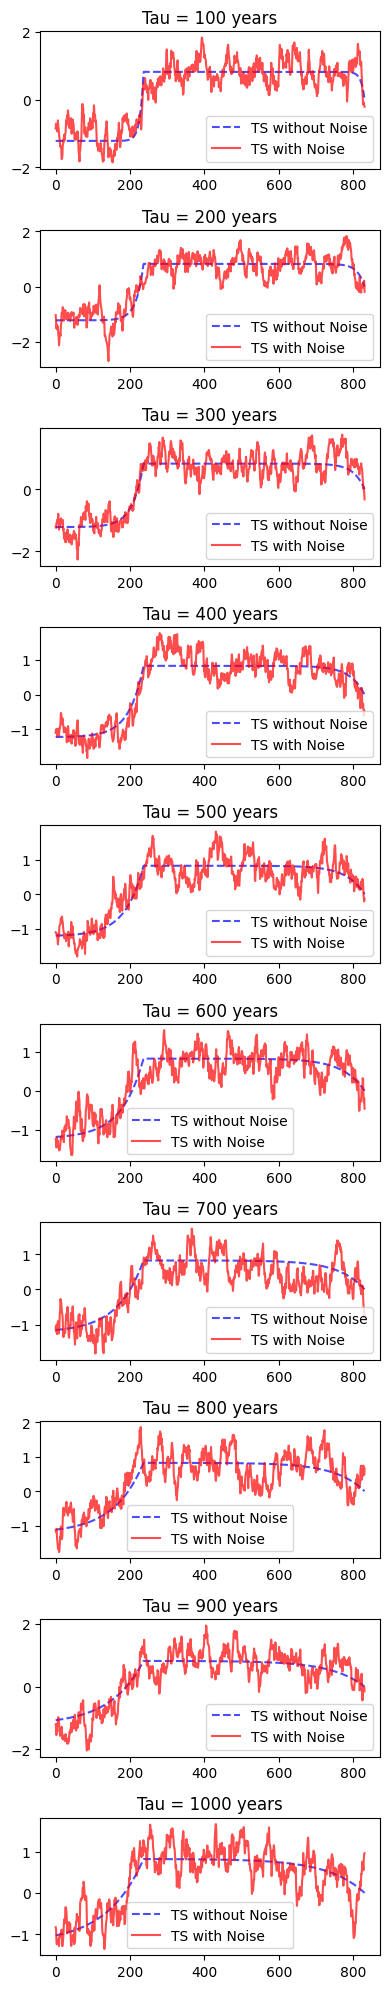

In [9]:
fig, axs = plt.subplots(10, 1, figsize=(4, 20), dpi=100)

# Loop through the first 10 tau values and plot TS with and without noise
for index, tau in enumerate(tau_values[:10]):
    # Generate TS without noise
    TS_without_noise = np.zeros(len(tn_time_series_resampled))
    TS_without_noise[-1] = TS_initial  # Start from the end for reverse calculation
    for i in range(len(tn_time_series_resampled) - 2, -1, -1):
        delta_TS = dt * (1/tau) * (-tn_time_series_resampled[i+1] - TS_without_noise[i+1])
        TS_without_noise[i] = TS_without_noise[i+1] + delta_TS

    # Generate red noise and TS with noise
    red_noise = np.zeros(len(TS_without_noise))
    red_noise[0] = np.random.normal(0, adjusted_std_dev)  # Initial red noise
    for i in range(1, len(TS_without_noise)):
        red_noise[i] = a * red_noise[i-1] + np.random.normal(0, adjusted_std_dev)
    TS_with_noise = TS_without_noise + red_noise

    # Plot TS without and with noise for this tau value
    axs[index].plot(TS_without_noise, label='TS without Noise', color='blue', alpha=0.7, linestyle='--')
    axs[index].plot(TS_with_noise, label='TS with Noise', color='red', alpha=0.7, linestyle='-')
    axs[index].set_title(f'Tau = {tau} years')
    axs[index].legend()

plt.tight_layout()
plt.show()

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntSlider

# Parameters
duration =5000
dt = 10
TS_initial = 0
a = 0.9

# Assuming a function to generate TN time series
def generate_test_TN_time_series(duration=40000):
    return np.ones(duration // dt) * -1  # Example TN series

def plot_TS(tau, std_factor):
    
    tn_time_series = generate_test_TN_time_series(duration)
    TS_without_noise = np.zeros_like(tn_time_series)
    TS_without_noise[-1] = TS_initial
    
    for i in range(len(tn_time_series) - 2, -1, -1):
        delta_TS = dt * (1/tau) * (-tn_time_series[i+1] - TS_without_noise[i+1])
        TS_without_noise[i] = TS_without_noise[i+1] + delta_TS

    variance_TS_without_noise = np.var(TS_without_noise)
    adjusted_std_dev = np.sqrt(variance_TS_without_noise) * std_factor

    np.random.seed(42)
    red_noise = np.zeros_like(tn_time_series)
    for i in range(1, len(tn_time_series)):
        red_noise[i] = a * red_noise[i-1] + np.random.normal(0, adjusted_std_dev)

    TS_with_noise = TS_without_noise + red_noise

    plt.clf()
    plt.plot(TS_without_noise, label='TS without Noise', linestyle='--')
    plt.plot(TS_with_noise, label='TS with Noise')
    plt.xlabel('Age (yr BP)')
    plt.ylabel('Temperature Anomaly (°C)')
    plt.legend()
    plt.show()

interactive_plot = interactive(plot_TS, tau=IntSlider(min=100, max=4000, step=100, value=1000, description='Tau', continuous_update=False),
                               std_factor=FloatSlider(min=0, max=4, step=0.1, value=0.5, description='Std Dev Factor', continuous_update=False))

display(interactive_plot)


interactive(children=(IntSlider(value=1000, continuous_update=False, description='Tau', max=4000, min=100, ste…